# Flooding Noise detection with YamNet, XGBoost and transfer learning

In [4]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
import xgboost as xgb
from sklearn.metrics import accuracy_score
import seaborn as sns

## Preprocessing
First, we create a dataframe with the sound file locations, their label (name and encoding) and their fold (i.e. train/test split)

In [5]:
df = pd.DataFrame({'filename':[], 'fold':[], 'target':[], 'category':[]})

directory = 'sound_full/yes'
for filename in os.listdir(directory):
    df = df.append({'filename':f'{directory}/{filename}', 'fold':0, 'target':0, 'category':'stream'}
             , ignore_index=True)

directory = 'sound_full/no'
for filename in os.listdir(directory):
    df = df.append({'filename':f'{directory}/{filename}', 'fold':0, 'target':1, 'category':'other'}
             , ignore_index=True)
df['target'] = df.target.astype('int')
df['fold'] = df.fold.astype('int')
df = shuffle(df)
df.reset_index(drop=True, inplace=True)
df['fold'] = df.apply(lambda x:0 if int(x.name)<=int(0.8*len(df)) else 1 , axis=1)

print(df.groupby('fold').size())
df.head()

fold
0    2220
1     554
dtype: int64


,filename,fold,target,category
0,sound_full/yes/stream-speech-3288.wav,0,0,stream
1,sound_full/yes/stream-speech-2175.wav,0,0,stream
2,sound_full/yes/stream-speech-1216.wav,0,0,stream
3,sound_full/no/rain-2764.wav,0,1,other
4,sound_full/no/rain-338.wav,0,1,other


We build the TensorFlow Dataset

In [7]:
filenames = df['filename']
targets = df['target']
folds = df['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Now, we extract the arrays from the wave files

In [8]:
@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [9]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

We load the YamNet model and compute its feature for the dataset:

In [11]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [12]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  cores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()

We do the train/test split

In [13]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold ==0)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 1)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

We convert the train/test sets into numpy to be compatible with XGBoost:

In [ ]:
def turn_numpy(ds):
    data = []
    label = []
    for i, (x,y) in enumerate(ds):
        data.append(x)
        label.append(y)
    data = np.stack(data)
    label = np.stack(label).reshape(-1,1)
    return data, label
x_train, y_train = turn_numpy(train_ds)
X_test, y_test = turn_numpy(test_ds)

We train an XGBoost Classifier:

In [17]:
xgb_cl = xgb.XGBClassifier(use_label_encoder=False)
xgb_cl.fit(x_train, y_train)
preds = xgb_cl.predict(X_test)
accuracy_score(y_test, preds)

[12:21:07] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7093667666030707

The confusion matrix:

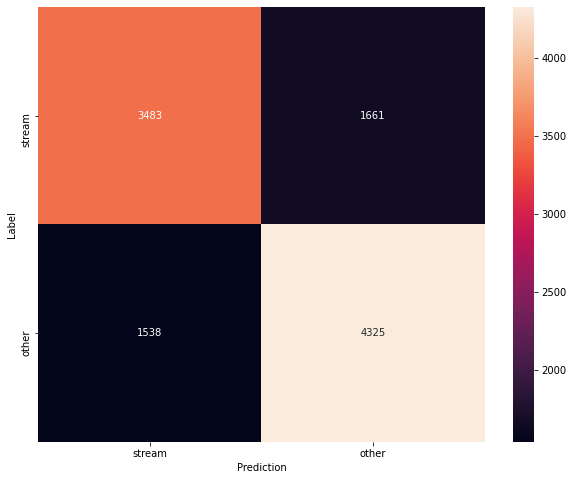

In [18]:
confusion_mtx = tf.math.confusion_matrix(y_test, preds) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=['stream', 'other'], yticklabels=['stream', 'other'], 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [19]:
xgb_cl.save_model("xgboost_model.json")